**Module Paths**

In [1]:
import os

os.chdir("./../..")

**Device**

In [2]:
from utils.device import get_device

device = get_device()
device

device(type='mps')

## Discriminator

The discriminator network is going to be a pretty typical linear classifier. To make this network a universal function approximator, we'll need at least one hidden layer, and these hidden layers should have one key attribute:
> All hidden layers will have a [Leaky ReLu](https://pytorch.org/docs/stable/nn.html#torch.nn.LeakyReLU) activation function applied to their outputs.

<img src='../assets/gan_network.png' width=70% />

#### Leaky ReLu

We should use a leaky ReLU to allow gradients to flow backwards through the layer unimpeded. A leaky ReLU is like a normal ReLU, except that there is a small non-zero output for negative input values.

<img src='../assets/leaky_relu.png' width=40% />

#### Output

We'll also take the approach of using a more numerically stable loss function on the outputs. Recall that we want the discriminator to output a value 0-1 indicating whether an image is _real or fake_. 
> We will ultimately use [BCEWithLogitsLoss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss), which combines a `sigmoid` activation function **and** binary cross entropy loss in one function. 

So, our final output layer should not have any activation function applied to it.

#### Structure

The discriminator takes a high dimensional input (for example, an image) and outputs a single score value. Linear layers in the discriminator should have a number of neurons such that the dimensions of their output is smaller than the dimension of their input.

In [3]:
import torch
import torch.nn as nn

In [4]:
class Discriminator(nn.Module):
    """
    Discriminator model:
    args:
    - input_dim: dimension of the input data. For example, for a 28 by 28 grayscale image, the input size is 784
    - hidden_dim: a parameter that controls the dimensions of the hidden layers.
    """

    def __init__(self, input_dim: int, hidden_dim: int):
        super(Discriminator, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        self.fc2 = nn.Linear(hidden_dim, hidden_dim // 2)
        self.fc3 = nn.Linear(hidden_dim // 2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = self.leaky_relu(x)
        x = self.fc2(x)
        x = self.leaky_relu(x)
        x = self.fc3(x)
        x = self.sigmoid(x)
        return x

## Generator

The generator network will be almost exactly the same as the discriminator network, except that we're applying a [tanh activation function](https://pytorch.org/docs/stable/nn.html#tanh) to our output layer.

#### tanh Output
The generator has been found to perform the best with $tanh$ for the generator output, which scales the output to be between -1 and 1, instead of 0 and 1. 

<img src='../assets/tanh_fn.png' width=40% />

Recall that we also want these outputs to be comparable to the *real* input pixel values, which are read in as normalized values between 0 and 1. 
> So, we'll also have to **scale our real input images to have pixel values between -1 and 1** when we train the discriminator. 

In [5]:
class Generator(nn.Module):
    def __init__(self, latent_dim: int, hidden_dim: int, output_size: int):
        super(Generator, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)
        self.leaky_relu = nn.LeakyReLU(negative_slope=0.01)
        self.fc2 = nn.Linear(hidden_dim, output_size)
        self.tanh = nn.Tanh()

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.fc1(x)
        x = self.leaky_relu(x)

        x = self.fc2(x)
        x = self.tanh(x)
        return x

# Tips for Training GANs

### Good Architecture

**Fully Connected Architecture** can be used for simple tasks that meet the following criteria:

1. No convolution
2. No recurrence
3. The generator and discriminator have at least one hidden layer

**Leaky ReLU** helps to ensure that the gradient can flow through the entire architecture and is a popular choice for hidden layer activation functions.

The **Hyperbolic Tangent** activation function is a popular output choice for the generator and means data should be scaled to the interval from -1 to +1.

A **Sigmoid Unit** is used to enforce the constraint that the output of the discriminator is a probability.

### Design Choice

One of the design choices from the DCGAN architecture is **Adam**, an optimization algorithm.

A common error is that people forget to use a numerically stable version of **cross-entropy**, where the loss is computed using the **logits**.

- **Logits** – the values produced by the discriminator right before the **sigmoid**.

### Tips for Training

1. A simple trick is to multiply the 0 or 1 labels by a number a bit less than 1. This is a GANs-specific label smoothing strategy similar to that used to regularize normal classifiers.
2. For the generator loss, minimize cross-entropy with the labels flipped.

### Scaling GANs

**Convolutional Neural Networks (CNN)** are needed to scale GANs to work on larger images. Scaling GANs relies on an understanding of:

- **Classifier Convolutional Net** – starting with a tall and wide feature map and moving to very short and narrow feature maps
- **Generator Net** – starting with short and narrow feature maps and moving to a wide and tall image
- **Batch Normalization** – applied to potentially every layer except the output layer of the generator and the input layer of the discriminator

## Discriminator and Generator Losses

Now we need to calculate the losses. 

### Discriminator Losses

> * For the discriminator, the total loss is the sum of the losses for real and fake images, `d_loss = d_real_loss + d_fake_loss`. 
* Remember that we want the discriminator to output 1 for real images and 0 for fake images, so we need to set up the losses to reflect that.

<img src='../assets/gan_pipeline.png' width=70% />

The losses will by binary cross entropy loss with logits, which we can get with [BCEWithLogitsLoss](https://pytorch.org/docs/stable/nn.html#bcewithlogitsloss). This combines a `sigmoid` activation function **and** and binary cross entropy loss in one function.

For the real images, we want `D(real_images) = 1`. That is, we want the discriminator to classify the the real images with a label = 1, indicating that these are real. To help the discriminator generalize better, the labels are **reduced a bit from 1.0 to 0.9**. For this, we'll use the parameter `smooth`; if True, then we should smooth our labels by a factor of 0.9
. 

The discriminator loss for the fake data is similar. We want `D(fake_images) = 0`, where the fake images are the _generator output_, `fake_images = G(z)`. 



In [6]:
# Calculate losses
def real_loss(D_out, smooth=False):
    ####
    target = torch.ones_like(D_out)
    if smooth:
        target *= 0.9

    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out, target)
    ####
    return loss

### Generator Loss

The generator loss will look similar only with flipped labels. The generator's goal is to get `D(fake_images) = 1`. In this case, the labels are **flipped** to represent that the generator is trying to fool the discriminator into thinking that the images it generates (fakes) are real!

In [7]:
def fake_loss(D_out):
    target = torch.zeros_like(D_out)
    criterion = nn.BCEWithLogitsLoss()
    loss = criterion(D_out, target)
    return loss

## Load the Data

In [8]:
from torchvision import transforms as T

train_transform = T.Compose([T.ToTensor()])

In [9]:
from data import DatasetWrapper

dataset_wrapper = DatasetWrapper(
    dataset_name="MNIST",
    root="./gan/mnist/data",
    train_transform=train_transform,
    download=True,
    train_ratio=1,
)

## Create DataLoader

In [10]:
from data import DataLoaderWrapper

train_dataset, _, _ = dataset_wrapper.get_datasets()

train_loader_wrapper = DataLoaderWrapper(
    dataset=train_dataset, batch_size=128, num_workers=4
)

train_loader = train_loader_wrapper.get_loader()

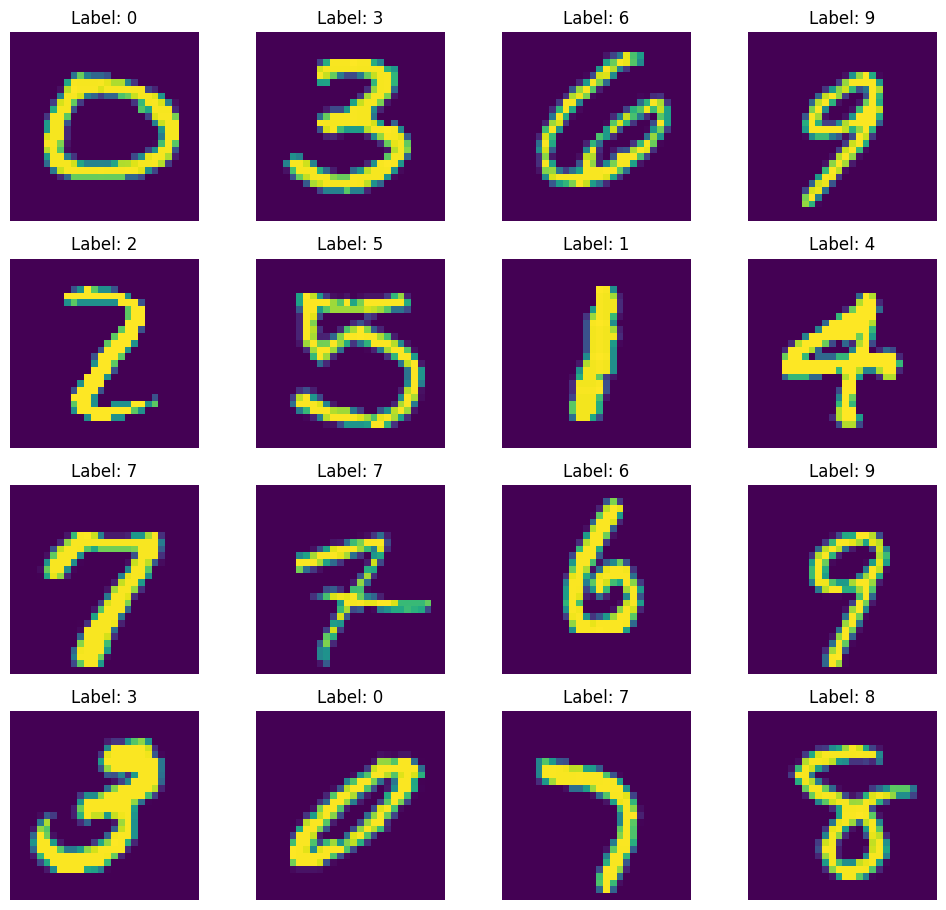

In [11]:
train_loader_wrapper.display_sample_images()

# Model hyperparameters

In [12]:
# Discriminator hyperparams

# Size of input image to discriminator (28*28)
input_size = 784
# Size of last hidden layer in the discriminator
d_hidden_size = 128

# Generator hyperparams

# Size of latent vector to give to generator
z_size = 100
# Size of discriminator output (generated image)
g_output_size = 784
# Size of first hidden layer in the generator
g_hidden_size = 32

## Initialize model, criterion, optimizer

In [13]:
# instantiate discriminator and generator
D = Discriminator(input_size, d_hidden_size)
G = Generator(z_size, g_hidden_size, g_output_size)

print(D)
print()
print(G)

Discriminator(
  (fc1): Linear(in_features=784, out_features=128, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.01)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)

Generator(
  (fc1): Linear(in_features=100, out_features=32, bias=True)
  (leaky_relu): LeakyReLU(negative_slope=0.01)
  (fc2): Linear(in_features=32, out_features=784, bias=True)
  (tanh): Tanh()
)


In [14]:
from optimize import OptimizerWrapper

# Optimizers
lr = 0.0002

# Create optimizers for the discriminator and generator
d_optimizer = OptimizerWrapper(D, "adam", lr=lr).get_optimizer()
g_optimizer = OptimizerWrapper(G, "adam", lr=lr).get_optimizer()

## Train the model

In [15]:
from trainer import GANTrainer

trainer = GANTrainer(
    G, D, train_loader, g_optimizer, d_optimizer, z_size, device=device
)

In [16]:
# Train the model for a few epochs
trainer.train(num_epochs=100, smooth=True, view_samples=False)

2024-11-04 16:21:55 | Batch 0/469 | d_loss: 1.4989 | g_loss: 0.4808
2024-11-04 16:21:56 | Batch 100/469 | d_loss: 1.2259 | g_loss: 0.5958
2024-11-04 16:21:56 | Batch 200/469 | d_loss: 1.2066 | g_loss: 0.5980
2024-11-04 16:21:57 | Batch 300/469 | d_loss: 1.1477 | g_loss: 0.6515
2024-11-04 16:21:58 | Batch 400/469 | d_loss: 1.1236 | g_loss: 0.6771
2024-11-04 16:22:00 | Batch 0/469 | d_loss: 1.1148 | g_loss: 0.6841
2024-11-04 16:22:00 | Batch 100/469 | d_loss: 1.1104 | g_loss: 0.6895
2024-11-04 16:22:01 | Batch 200/469 | d_loss: 1.1094 | g_loss: 0.6902
2024-11-04 16:22:02 | Batch 300/469 | d_loss: 1.1090 | g_loss: 0.6905
2024-11-04 16:22:02 | Batch 400/469 | d_loss: 1.1086 | g_loss: 0.6909
2024-11-04 16:22:04 | Batch 0/469 | d_loss: 1.1081 | g_loss: 0.6915
2024-11-04 16:22:05 | Batch 100/469 | d_loss: 1.1075 | g_loss: 0.6920
2024-11-04 16:22:06 | Batch 200/469 | d_loss: 1.1072 | g_loss: 0.6923
2024-11-04 16:22:06 | Batch 300/469 | d_loss: 1.1070 | g_loss: 0.6925
2024-11-04 16:22:07 | Batc

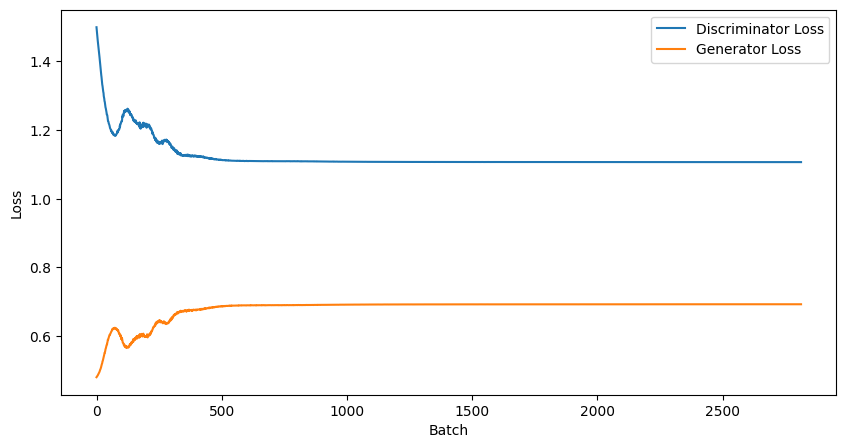

In [17]:
# Plot the trainer metrics
trainer.plot_metrics()

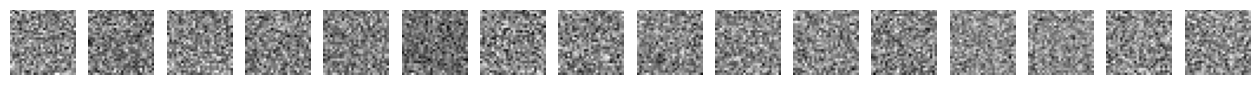

In [18]:
# Visualizing the final samples
trainer.view_samples(-1)